In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import os
import matplotlib.style
from pandas.core.common import flatten
from functools import partial, reduce

In [2]:

plt.style.use('ggplot')

path = 'C:\\Work\Projects\\python\\flask\strategies\\data'

pairs_list = []
for filename in os.listdir(path):
    if filename.endswith('.csv'):
        pairs_list.append(filename.split('.')[0])
print(pairs_list)

['AUDUSD', 'EURUSD', 'GBPUSD', 'NZDUSD', 'USDCAD', 'USDCHF', 'USDJPY']


AUDUSD
EURUSD
GBPUSD
NZDUSD
USDCAD
USDCHF
USDJPY


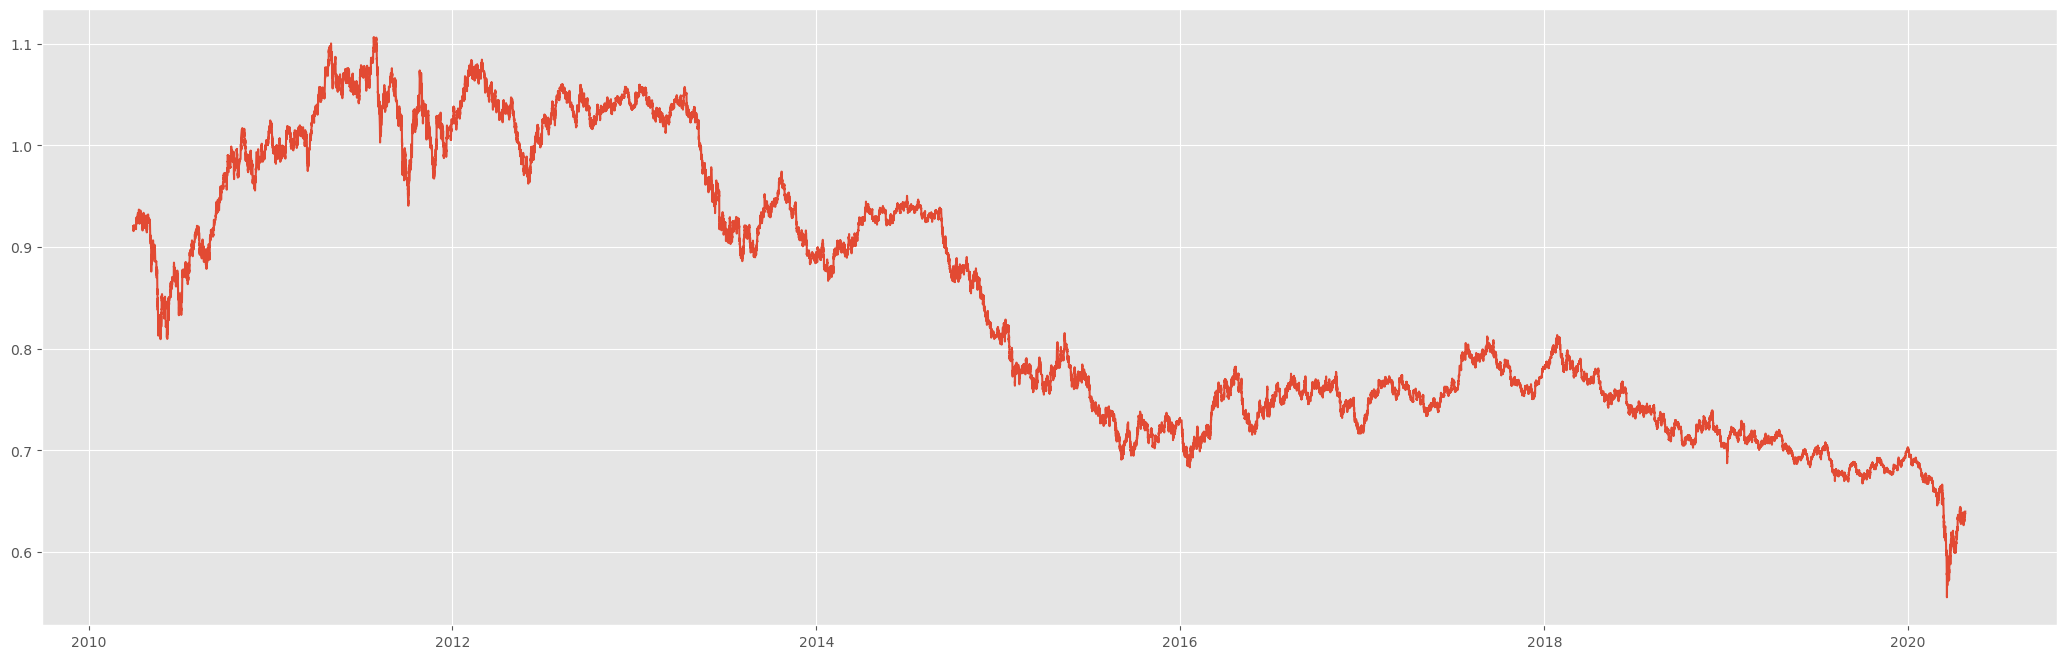

In [3]:

df = {}
for pair in range(len(pairs_list)):
    print(pairs_list[pair])
    df[pair] = pd.read_csv('C:\\Work\Projects\\python\\flask\strategies\\data\\'+pairs_list[pair]+'.csv', header = 0)
    df[pair].columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    df[pair]['Date'] = df[pair]['Date'].str.split(' ').str[0:2]
    df[pair]['Date'] = df[pair]['Date'].str.join(' ')
    df[pair].set_index('Date', inplace = True)
    df[pair].index = pd.to_datetime(df[pair].index, format = '%d.%m.%Y %H:%M:%S.%f')

plt.figure(figsize = (26, 8))
plt.plot(df[0]['Close'])

In [4]:

def SMA(df, fast, slow):
    df['sma_fast'] = df['Close'].rolling(fast).mean()
    df['sma_slow'] = df['Close'].rolling(slow).mean()
    return df

In [5]:

def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis = 1, skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis = 1)
    return df

In [6]:

#Strategy parameters
account_size = 10000
slippage = 2
size = 1
ATR_SL = 0.5

In [7]:

for pair in range(len(pairs_list)):
    df[pair]['ATR'] = ATR(df[pair], 20)['ATR']
    df[pair]['sma_fast'] = SMA(df[pair], 50, 100)['sma_fast']
    df[pair]['sma_slow'] = SMA(df[pair], 50, 100)['sma_slow']
    if 'JPY' not in pairs_list[pair]:
        df[pair]['spread'] = float(slippage) / float(10000)
        df[pair]['size'] = float(size) * float(10000)
        print('Pair: ', pairs_list[pair], 'a')
    else:
        df[pair]['spread'] = float(slippage) / float(100)
        df[pair]['size'] = float(size) * float(100)
        print('Pair: ', pairs_list[pair], 'b')


Pair:  AUDUSD a
Pair:  EURUSD a
Pair:  GBPUSD a
Pair:  NZDUSD a
Pair:  USDCAD a
Pair:  USDCHF a
Pair:  USDJPY b


In [8]:

open_trade = {}
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}

for pair in range(len(pairs_list)):
    open_trade[pair] = []
    trade[pair] = {}
    long_take_profit[pair] = []
    short_take_profit[pair] = []
    long_stop_loss[pair] = []
    short_stop_loss[pair] = []
    long_entry_price[pair] = []
    short_entry_price[pair] = []

    for i in range(50, len(df[pair])):
        #Buy
        if df[pair]['sma_fast'][i-1] < df[pair]['sma_slow'][i-1] and df[pair]['sma_fast'][i] >= df[pair]['sma_slow'][i] and len(open_trade[pair]) == 0:
            print(i, 'New Long trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                             'date_of_trade': df[pair].index[i],
                             'entry_price': df[pair]['Close'][i],
                             'signal': 'Buy',
                             'result': 0,
                             'TP': df[pair]['Close'][i] + df[pair]['ATR'][i] * ATR_SL,
                             'SL': df[pair]['Close'][i] - df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])

        #Sell
        if df[pair]['sma_fast'][i-1] > df[pair]['sma_slow'][i-1] and df[pair]['sma_fast'][i] <= df[pair]['sma_slow'][i] and len(open_trade[pair]) == 0:
            print(i, 'New Short trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                             'date_of_trade': df[pair].index[i],
                             'entry_price': df[pair]['Close'][i],
                             'signal': 'Sell',
                             'result': 0,
                             'TP': df[pair]['Close'][i] - df[pair]['ATR'][i] * ATR_SL,
                             'SL': df[pair]['Close'][i] + df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            short_take_profit[pair].append(trade[pair][i]['TP'])
            short_stop_loss[pair].append(trade[pair][i]['SL'])
            short_entry_price[pair].append(trade[pair][i]['entry_price'])

        #Exit trades---------------------------------------------------------------------------
        #Buy profit
        if any(y <= df[pair]['Close'][i] for y in long_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] >= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['TP'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                             'Long profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Buy loss
        if any(y >= df[pair]['Close'][i] for y in long_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] <= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['SL'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                             'Long loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])

        #Sell profit
        if any(y >= df[pair]['Close'][i] for y in short_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] <= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['TP'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                             'Short profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Sell loss
        if any(y <= df[pair]['Close'][i] for y in short_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] >= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['SL'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                             'Short loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Exit after time
        if len(open_trade[pair]) != 0:
            for j in open_trade[pair]:
                if (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    trade[pair][j].update({'result' : (df[pair]['Close'][i] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j,
                         'Long exited after 12 hours:', round(df[pair]['Close'][i], 4),
                         'On day:', df[pair].index[i],
                         'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    long_take_profit[pair].remove(trade[pair][j]['TP'])
                    long_stop_loss[pair].remove(trade[pair][j]['SL'])
                elif (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - df[pair]['Close'][i] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j,
                         'Short exited after 12 hours:', round(df[pair]['Close'][i], 4),
                         'On day:', df[pair].index[i],
                         'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    short_take_profit[pair].remove(trade[pair][j]['TP'])
                    short_stop_loss[pair].remove(trade[pair][j]['SL'])

pairs_results = {}
profits = {}
losses = {}
be = {}

216 New Short trade at price: 0.9287  On day: 2010-04-14 00:00:00 Pair: AUDUSD
216 Short loss at price: 0.9315 On day: 2010-04-14 01:00:00 With loss: -10.0075 

243 New Long trade at price: 0.9347  On day: 2010-04-15 03:00:00 Pair: AUDUSD
243 Long loss at price: 0.934 On day: 2010-04-15 06:00:00 With loss: -8.5675 

292 New Short trade at price: 0.9193  On day: 2010-04-19 04:00:00 Pair: AUDUSD
292 Short profit at price: 0.9164 On day: 2010-04-19 07:00:00 With profit: 9.4975 

349 New Long trade at price: 0.9299  On day: 2010-04-21 13:00:00 Pair: AUDUSD
349 Long loss at price: 0.929 On day: 2010-04-21 15:00:00 With loss: -9.5725 

394 New Short trade at price: 0.9214  On day: 2010-04-23 10:00:00 Pair: AUDUSD
394 Short profit at price: 0.919 On day: 2010-04-23 13:00:00 With profit: 9.145 

447 New Long trade at price: 0.9251  On day: 2010-04-27 15:00:00 Pair: AUDUSD
447 Long loss at price: 0.9169 On day: 2010-04-27 16:00:00 With loss: -9.98 

455 New Short trade at price: 0.9165  On day:

5543 New Long trade at price: 1.012  On day: 2011-02-17 21:00:00 Pair: AUDUSD
5543 Long loss at price: 1.011 On day: 2011-02-17 22:00:00 With loss: -12.0075 

5614 New Short trade at price: 0.9975  On day: 2011-02-22 19:00:00 Pair: AUDUSD
5614 Short loss at price: 0.999 On day: 2011-02-22 21:00:00 With loss: -15.5725 

5672 New Long trade at price: 1.012  On day: 2011-02-25 05:00:00 Pair: AUDUSD
5672 Long profit at price: 1.0131 On day: 2011-02-25 07:00:00 With profit: 8.165 

5766 New Short trade at price: 1.0153  On day: 2011-03-03 02:00:00 Pair: AUDUSD
5766 Short loss at price: 1.0171 On day: 2011-03-03 05:00:00 With loss: -10.7425 

5956 New Long trade at price: 1.0088  On day: 2011-03-14 23:00:00 Pair: AUDUSD
5956 Long loss at price: 1.0067 On day: 2011-03-15 00:00:00 With loss: -11.505 

5972 New Short trade at price: 0.9901  On day: 2011-03-15 15:00:00 Pair: AUDUSD
5972 Short loss at price: 0.9939 On day: 2011-03-15 23:00:00 With loss: -21.025 

6058 New Long trade at price: 1.0

10060 New Short trade at price: 1.0378  On day: 2011-11-08 23:00:00 Pair: AUDUSD
10060 Short profit at price: 1.0357 On day: 2011-11-09 03:00:00 With profit: 12.1675 

10155 New Long trade at price: 1.0207  On day: 2011-11-14 21:00:00 Pair: AUDUSD
10155 Long profit at price: 1.0221 On day: 2011-11-15 00:00:00 With profit: 11.6475 

10187 New Short trade at price: 1.0074  On day: 2011-11-16 05:00:00 Pair: AUDUSD
10187 Short loss at price: 1.01 On day: 2011-11-16 07:00:00 With loss: -16.5775 

10390 New Long trade at price: 0.9962  On day: 2011-11-28 14:00:00 Pair: AUDUSD
10390 Long loss at price: 0.9934 On day: 2011-11-28 15:00:00 With loss: -20.49 

10536 New Short trade at price: 1.0226  On day: 2011-12-06 16:00:00 Pair: AUDUSD
10536 Short loss at price: 1.0262 On day: 2011-12-06 19:00:00 With loss: -16.0975 

10570 New Short trade at price: 1.0251  On day: 2011-12-08 02:00:00 Pair: AUDUSD
10570 Short loss at price: 1.0269 On day: 2011-12-08 04:00:00 With loss: -13.6375 

10597 New Sh

17493 New Short trade at price: 1.0538  On day: 2013-01-15 13:00:00 Pair: AUDUSD
17493 Short loss at price: 1.055 On day: 2013-01-15 15:00:00 With loss: -8.38 

17620 New Long trade at price: 1.0566  On day: 2013-01-22 20:00:00 Pair: AUDUSD
17620 Long loss at price: 1.0556 On day: 2013-01-23 00:00:00 With loss: -8.3725 

17668 New Short trade at price: 1.0463  On day: 2013-01-24 20:00:00 Pair: AUDUSD
17668 Short profit at price: 1.0452 On day: 2013-01-24 21:00:00 With profit: 5.855 

17757 New Long trade at price: 1.0426  On day: 2013-01-30 13:00:00 Pair: AUDUSD
17757 Long loss at price: 1.0412 On day: 2013-01-30 14:00:00 With loss: -7.12 

17793 New Short trade at price: 1.0406  On day: 2013-02-01 01:00:00 Pair: AUDUSD
17793 Short profit at price: 1.0391 On day: 2013-02-01 04:00:00 With profit: 5.455 

17851 New Long trade at price: 1.0391  On day: 2013-02-05 11:00:00 Pair: AUDUSD
17851 Long loss at price: 1.0382 On day: 2013-02-05 15:00:00 With loss: -9.61 

17867 New Short trade at 

22532 New Long trade at price: 0.9532  On day: 2013-11-05 12:00:00 Pair: AUDUSD
22532 Long loss at price: 0.9505 On day: 2013-11-05 13:00:00 With loss: -9.195 

22593 New Short trade at price: 0.9456  On day: 2013-11-08 01:00:00 Pair: AUDUSD
22593 Short loss at price: 0.9467 On day: 2013-11-08 05:00:00 With loss: -12.065 

22724 New Long trade at price: 0.9327  On day: 2013-11-15 12:00:00 Pair: AUDUSD
22724 Long profit at price: 0.9345 On day: 2013-11-15 13:00:00 With profit: 4.465 

22818 New Short trade at price: 0.9267  On day: 2013-11-21 10:00:00 Pair: AUDUSD
22818 Short profit at price: 0.9248 On day: 2013-11-21 13:00:00 With profit: 7.6225 

22986 New Long trade at price: 0.9132  On day: 2013-12-02 10:00:00 Pair: AUDUSD
22986 Long profit at price: 0.9146 On day: 2013-12-02 12:00:00 With profit: 6.605 

23030 New Short trade at price: 0.9035  On day: 2013-12-04 06:00:00 Pair: AUDUSD
23030 Short profit at price: 0.9018 On day: 2013-12-04 09:00:00 With profit: 7.03 

23103 New Long 

27209 New Long trade at price: 0.9337  On day: 2014-08-05 09:00:00 Pair: AUDUSD
27209 Long loss at price: 0.9328 On day: 2014-08-05 10:00:00 With loss: -5.5975 

27256 New Short trade at price: 0.9268  On day: 2014-08-07 08:00:00 Pair: AUDUSD
27256 Short loss at price: 0.9276 On day: 2014-08-07 12:00:00 With loss: -9.4575 

27357 New Long trade at price: 0.9317  On day: 2014-08-13 13:00:00 Pair: AUDUSD
27357 Long loss at price: 0.9307 On day: 2014-08-13 15:00:00 With loss: -6.7475 

27473 New Short trade at price: 0.9292  On day: 2014-08-20 09:00:00 Pair: AUDUSD
27473 Short profit at price: 0.9284 On day: 2014-08-20 10:00:00 With profit: 3.74 

27542 New Long trade at price: 0.9321  On day: 2014-08-25 06:00:00 Pair: AUDUSD
27542 Long loss at price: 0.9315 On day: 2014-08-25 09:00:00 With loss: -7.3025 

27682 New Short trade at price: 0.9314  On day: 2014-09-02 02:00:00 Pair: AUDUSD
27682 Short profit at price: 0.9304 On day: 2014-09-02 03:00:00 With profit: 1.1 

27746 New Long trade 

34288 New Short trade at price: 0.7145  On day: 2015-09-22 08:00:00 Pair: AUDUSD
34288 Short profit at price: 0.7115 On day: 2015-09-22 09:00:00 With profit: 4.3075 

34454 New Long trade at price: 0.7056  On day: 2015-10-01 06:00:00 Pair: AUDUSD
34454 Long profit at price: 0.7064 On day: 2015-10-01 07:00:00 With profit: 5.335 

34678 New Short trade at price: 0.7267  On day: 2015-10-14 14:00:00 Pair: AUDUSD
34678 Short profit at price: 0.7256 On day: 2015-10-14 16:00:00 With profit: 8.5875 

34723 New Long trade at price: 0.7278  On day: 2015-10-16 11:00:00 Pair: AUDUSD
34723 Long loss at price: 0.7267 On day: 2015-10-16 12:00:00 With loss: -10.0125 

34756 New Short trade at price: 0.7247  On day: 2015-10-19 20:00:00 Pair: AUDUSD
34756 Short loss at price: 0.7259 On day: 2015-10-20 00:00:00 With loss: -9.865 

34871 New Long trade at price: 0.7257  On day: 2015-10-26 14:00:00 Pair: AUDUSD
34871 Long loss at price: 0.725 On day: 2015-10-26 18:00:00 With loss: -8.3 

34909 New Short tr

39244 New Short trade at price: 0.752  On day: 2016-07-06 20:00:00 Pair: AUDUSD
39244 Short profit at price: 0.7498 On day: 2016-07-07 02:00:00 With profit: 7.9575 

39279 New Long trade at price: 0.7491  On day: 2016-07-08 07:00:00 Pair: AUDUSD
39279 Long profit at price: 0.7498 On day: 2016-07-08 08:00:00 With profit: 4.8425 

39427 New Short trade at price: 0.7593  On day: 2016-07-18 11:00:00 Pair: AUDUSD
39427 Short profit at price: 0.7584 On day: 2016-07-18 13:00:00 With profit: 5.4725 

39577 New Long trade at price: 0.7513  On day: 2016-07-26 17:00:00 Pair: AUDUSD
39577 Long loss at price: 0.7505 On day: 2016-07-26 21:00:00 With loss: -8.935 

39901 New Short trade at price: 0.7647  On day: 2016-08-15 05:00:00 Pair: AUDUSD
39901 Short loss at price: 0.7658 On day: 2016-08-15 06:00:00 With loss: -9.2725 

39951 New Long trade at price: 0.7673  On day: 2016-08-17 07:00:00 Pair: AUDUSD
39951 Long loss at price: 0.7637 On day: 2016-08-17 09:00:00 With loss: -10.7675 

39982 New Shor

45780 New Short trade at price: 0.7924  On day: 2017-07-24 04:00:00 Pair: AUDUSD
45780 Short loss at price: 0.7951 On day: 2017-07-24 08:00:00 With loss: -7.9475 

45820 New Long trade at price: 0.7937  On day: 2017-07-25 20:00:00 Pair: AUDUSD
45820 Long loss at price: 0.7927 On day: 2017-07-26 01:00:00 With loss: -8.835 

45838 New Short trade at price: 0.7915  On day: 2017-07-26 14:00:00 Pair: AUDUSD
45838 Short loss at price: 0.7926 On day: 2017-07-26 15:00:00 With loss: -8.995 

45844 New Long trade at price: 0.799  On day: 2017-07-26 20:00:00 Pair: AUDUSD
45844 Long profit at price: 0.8006 On day: 2017-07-26 21:00:00 With profit: 7.7725 

45941 New Short trade at price: 0.7969  On day: 2017-08-01 21:00:00 Pair: AUDUSD
45941 Short profit at price: 0.796 On day: 2017-08-01 23:00:00 With profit: 6.5375 

45952 New Long trade at price: 0.7959  On day: 2017-08-02 08:00:00 Pair: AUDUSD
45952 Long profit at price: 0.7968 On day: 2017-08-02 09:00:00 With profit: 5.4525 

45969 New Short t

50683 New Long trade at price: 0.752  On day: 2018-05-04 11:00:00 Pair: AUDUSD
50683 Long profit at price: 0.7535 On day: 2018-05-04 13:00:00 With profit: 3.5025 

50730 New Short trade at price: 0.7458  On day: 2018-05-08 10:00:00 Pair: AUDUSD
50730 Short profit at price: 0.7437 On day: 2018-05-08 14:00:00 With profit: 5.145 

50799 New Long trade at price: 0.7539  On day: 2018-05-11 07:00:00 Pair: AUDUSD
50799 Long profit at price: 0.7552 On day: 2018-05-11 09:00:00 With profit: 4.8575 

50866 New Short trade at price: 0.7457  On day: 2018-05-16 02:00:00 Pair: AUDUSD
50866 Short loss at price: 0.7468 On day: 2018-05-16 03:00:00 With loss: -9.4 

50919 New Long trade at price: 0.7523  On day: 2018-05-18 07:00:00 Pair: AUDUSD
50919 Long loss at price: 0.7514 On day: 2018-05-18 08:00:00 With loss: -7.09 

51030 New Short trade at price: 0.7578  On day: 2018-05-24 22:00:00 Pair: AUDUSD
51030 Short profit at price: 0.7571 On day: 2018-05-25 00:00:00 With profit: 3.4025 

51062 New Long tr

56224 New Short trade at price: 0.7087  On day: 2019-03-25 07:00:00 Pair: AUDUSD
56224 Short loss at price: 0.7093 On day: 2019-03-25 09:00:00 With loss: -6.5025 

56266 New Long trade at price: 0.711  On day: 2019-03-27 01:00:00 Pair: AUDUSD
56266 Long loss at price: 0.7104 On day: 2019-03-27 03:00:00 With loss: -6.395 

56304 New Short trade at price: 0.7079  On day: 2019-03-28 15:00:00 Pair: AUDUSD
56304 Short profit at price: 0.7068 On day: 2019-03-28 16:00:00 With profit: 3.06 

56354 New Long trade at price: 0.7116  On day: 2019-04-01 18:00:00 Pair: AUDUSD
56354 Long loss at price: 0.7106 On day: 2019-04-01 22:00:00 With loss: -6.12 

56395 New Short trade at price: 0.7116  On day: 2019-04-03 11:00:00 Pair: AUDUSD
56395 Short loss at price: 0.7125 On day: 2019-04-03 16:00:00 With loss: -7.0775 

56425 New Long trade at price: 0.7117  On day: 2019-04-04 17:00:00 Pair: AUDUSD
56425 Long loss at price: 0.7113 On day: 2019-04-04 22:00:00 With loss: -6.1 

56484 New Short trade at pri

62952 New Long trade at price: 0.6387  On day: 2020-04-20 16:00:00 Pair: AUDUSD
62952 Long loss at price: 0.6372 On day: 2020-04-20 17:00:00 With loss: -10.53 

62983 New Short trade at price: 0.6282  On day: 2020-04-21 23:00:00 Pair: AUDUSD
62983 Short loss at price: 0.6293 On day: 2020-04-22 00:00:00 With loss: -12.6825 

63031 New Long trade at price: 0.6375  On day: 2020-04-23 23:00:00 Pair: AUDUSD
63031 Long loss at price: 0.6362 On day: 2020-04-24 01:00:00 With loss: -11.4 

169 New Long trade at price: 1.3633  On day: 2010-04-12 01:00:00 Pair: EURUSD
169 Long profit at price: 1.3686 On day: 2010-04-12 05:00:00 With profit: 18.295 

271 New Short trade at price: 1.3531  On day: 2010-04-16 07:00:00 Pair: EURUSD
271 Short loss at price: 1.356 On day: 2010-04-16 09:00:00 With loss: -13.6025 

441 New Long trade at price: 1.3356  On day: 2010-04-27 09:00:00 Pair: EURUSD
441 Long loss at price: 1.3319 On day: 2010-04-27 10:00:00 With loss: -14.875 

455 New Short trade at price: 1.317

7064 New Long trade at price: 1.4256  On day: 2011-05-18 08:00:00 Pair: EURUSD
7064 Long loss at price: 1.4236 On day: 2011-05-18 12:00:00 With loss: -16.4975 

7135 New Short trade at price: 1.4026  On day: 2011-05-23 07:00:00 Pair: EURUSD
7135 Short profit at price: 1.3991 On day: 2011-05-23 09:00:00 With profit: 16.9175 

7212 New Long trade at price: 1.4183  On day: 2011-05-26 12:00:00 Pair: EURUSD
7212 Long loss at price: 1.4155 On day: 2011-05-26 14:00:00 With loss: -15.455 

7458 New Short trade at price: 1.4512  On day: 2011-06-09 18:00:00 Pair: EURUSD
7458 Short loss at price: 1.4538 On day: 2011-06-10 00:00:00 With loss: -16.4275 

7631 New Long trade at price: 1.4324  On day: 2011-06-20 23:00:00 Pair: EURUSD
7631 Long profit at price: 1.4362 On day: 2011-06-21 00:00:00 With profit: 12.285 

7704 New Short trade at price: 1.4262  On day: 2011-06-24 00:00:00 Pair: EURUSD
7704 Short profit at price: 1.424 On day: 2011-06-24 07:00:00 With profit: 14.77 

7774 New Long trade at p

12389 New Short trade at price: 1.3203  On day: 2012-03-23 04:00:00 Pair: EURUSD
12389 Short loss at price: 1.3239 On day: 2012-03-23 07:00:00 With loss: -10.9675 

12421 New Long trade at price: 1.3313  On day: 2012-03-26 13:00:00 Pair: EURUSD
12421 Long profit at price: 1.3326 On day: 2012-03-26 15:00:00 With profit: 8.77 

12504 New Short trade at price: 1.3315  On day: 2012-03-30 00:00:00 Pair: EURUSD
12504 Short loss at price: 1.3343 On day: 2012-03-30 01:00:00 With loss: -12.1675 

12540 New Long trade at price: 1.3328  On day: 2012-04-02 12:00:00 Pair: EURUSD
12540 Long loss at price: 1.3309 On day: 2012-04-02 13:00:00 With loss: -10.835 

12577 New Short trade at price: 1.3226  On day: 2012-04-04 01:00:00 Pair: EURUSD
12577 Short profit at price: 1.3195 On day: 2012-04-04 02:00:00 With profit: 10.2825 

12698 New Long trade at price: 1.3079  On day: 2012-04-11 02:00:00 Pair: EURUSD
12698 Long profit at price: 1.3092 On day: 2012-04-11 04:00:00 With profit: 9.3425 

12783 New Sh

18546 New Long trade at price: 1.2958  On day: 2013-03-18 17:00:00 Pair: EURUSD
18546 Long loss at price: 1.2931 On day: 2013-03-18 19:00:00 With loss: -14.765 

18635 New Long trade at price: 1.2937  On day: 2013-03-22 10:00:00 Pair: EURUSD
18635 Long profit at price: 1.2948 On day: 2013-03-22 11:00:00 With profit: 7.3525 

18690 New Short trade at price: 1.2854  On day: 2013-03-26 17:00:00 Pair: EURUSD
18690 Short loss at price: 1.2864 On day: 2013-03-26 22:00:00 With loss: -11.8825 

18783 New Long trade at price: 1.2847  On day: 2013-04-01 15:00:00 Pair: EURUSD
18783 Long profit at price: 1.2858 On day: 2013-04-01 16:00:00 With profit: 4.5225 

18852 New Short trade at price: 1.2812  On day: 2013-04-04 12:00:00 Pair: EURUSD
18852 Short profit at price: 1.2773 On day: 2013-04-04 13:00:00 With profit: 4.9075 

18858 New Long trade at price: 1.2938  On day: 2013-04-04 18:00:00 Pair: EURUSD
18858 Long loss at price: 1.2919 On day: 2013-04-05 06:00:00 With loss: -16.13 

19030 New Short

24968 New Short trade at price: 1.3774  On day: 2014-03-27 07:00:00 Pair: EURUSD
24968 Short profit at price: 1.3765 On day: 2014-03-27 08:00:00 With profit: 4.5675 

25044 New Long trade at price: 1.3791  On day: 2014-04-01 12:00:00 Pair: EURUSD
25044 Long profit at price: 1.38 On day: 2014-04-01 13:00:00 With profit: 2.835 

25099 New Short trade at price: 1.3715  On day: 2014-04-03 19:00:00 Pair: EURUSD
25099 Short profit at price: 1.3706 On day: 2014-04-04 06:00:00 With profit: 5.745 

25170 New Long trade at price: 1.3796  On day: 2014-04-08 18:00:00 Pair: EURUSD
25170 Long loss at price: 1.3789 On day: 2014-04-09 01:00:00 With loss: -7.2475 

25279 New Short trade at price: 1.3813  On day: 2014-04-15 07:00:00 Pair: EURUSD
25279 Short profit at price: 1.3801 On day: 2014-04-15 08:00:00 With profit: 2.1175 

25342 New Long trade at price: 1.3814  On day: 2014-04-17 22:00:00 Pair: EURUSD
25342 Long profit at price: 1.3819 On day: 2014-04-18 07:00:00 With profit: 2.8525 

25379 New S

30131 New Long trade at price: 1.1627  On day: 2015-01-22 11:00:00 Pair: EURUSD
30131 Long loss at price: 1.1563 On day: 2015-01-22 13:00:00 With loss: -12.065 

30134 New Short trade at price: 1.1464  On day: 2015-01-22 14:00:00 Pair: EURUSD
30134 Short profit at price: 1.1418 On day: 2015-01-22 15:00:00 With profit: 13.8275 

30229 New Long trade at price: 1.1351  On day: 2015-01-28 13:00:00 Pair: EURUSD
30229 Long loss at price: 1.1308 On day: 2015-01-28 14:00:00 With loss: -12.155 

30281 New Short trade at price: 1.1288  On day: 2015-01-30 17:00:00 Pair: EURUSD
30281 Short loss at price: 1.13 On day: 2015-01-30 20:00:00 With loss: -14.04 

30313 New Long trade at price: 1.1348  On day: 2015-02-03 01:00:00 Pair: EURUSD
30313 Long loss at price: 1.1331 On day: 2015-02-03 03:00:00 With loss: -12.175 

30404 New Short trade at price: 1.132  On day: 2015-02-06 20:00:00 Pair: EURUSD
30404 Short loss at price: 1.1338 On day: 2015-02-09 02:00:00 With loss: -13.535 

30497 New Long trade a

34983 New Long trade at price: 1.1036  On day: 2015-11-02 15:00:00 Pair: EURUSD
34983 Long loss at price: 1.1024 On day: 2015-11-02 16:00:00 With loss: -11.4825 

35024 New Short trade at price: 1.0924  On day: 2015-11-04 08:00:00 Pair: EURUSD
35024 Short loss at price: 1.0934 On day: 2015-11-04 12:00:00 With loss: -9.74 

35180 New Long trade at price: 1.081  On day: 2015-11-12 20:00:00 Pair: EURUSD
35180 Long loss at price: 1.0788 On day: 2015-11-13 01:00:00 With loss: -15.0625 

35230 New Short trade at price: 1.0684  On day: 2015-11-16 22:00:00 Pair: EURUSD
35230 Short profit at price: 1.0666 On day: 2015-11-17 01:00:00 With profit: 6.4825 

35306 New Long trade at price: 1.0722  On day: 2015-11-20 02:00:00 Pair: EURUSD
35306 Long loss at price: 1.0689 On day: 2015-11-20 07:00:00 With loss: -11.7175 

35346 New Short trade at price: 1.0622  On day: 2015-11-23 18:00:00 Pair: EURUSD
35346 Short loss at price: 1.0636 On day: 2015-11-23 21:00:00 With loss: -11.0 

35510 New Long trade 

40048 New Short trade at price: 1.1307  On day: 2016-08-23 16:00:00 Pair: EURUSD
40048 Short loss at price: 1.1318 On day: 2016-08-23 17:00:00 With loss: -7.6025 

40234 New Long trade at price: 1.118  On day: 2016-09-02 10:00:00 Pair: EURUSD
40234 Long profit at price: 1.1191 On day: 2016-09-02 12:00:00 With profit: 3.77 

40280 New Short trade at price: 1.116  On day: 2016-09-06 08:00:00 Pair: EURUSD
40280 Short loss at price: 1.1164 On day: 2016-09-06 10:00:00 With loss: -5.955 

40295 New Long trade at price: 1.1245  On day: 2016-09-06 23:00:00 Pair: EURUSD
40295 Long profit at price: 1.1253 On day: 2016-09-07 03:00:00 With profit: 5.365 

40384 New Short trade at price: 1.1229  On day: 2016-09-12 16:00:00 Pair: EURUSD
40384 Short loss at price: 1.1253 On day: 2016-09-12 18:00:00 With loss: -8.7925 

40453 New Long trade at price: 1.1247  On day: 2016-09-15 13:00:00 Pair: EURUSD
40453 Long loss at price: 1.123 On day: 2016-09-15 14:00:00 With loss: -7.66 

40484 New Short trade at 

46128 New Long trade at price: 1.1825  On day: 2017-08-14 00:00:00 Pair: EURUSD
46128 Long loss at price: 1.1808 On day: 2017-08-14 08:00:00 With loss: -11.5325 

46179 New Short trade at price: 1.1737  On day: 2017-08-16 03:00:00 Pair: EURUSD
46179 Short profit at price: 1.1716 On day: 2017-08-16 08:00:00 With profit: 6.0325 

46243 New Long trade at price: 1.1759  On day: 2017-08-18 19:00:00 Pair: EURUSD
46243 Long loss at price: 1.1746 On day: 2017-08-21 06:00:00 With loss: -10.9775 

46260 New Long trade at price: 1.1764  On day: 2017-08-21 12:00:00 Pair: EURUSD
46260 Long profit at price: 1.178 On day: 2017-08-21 13:00:00 With profit: 2.9 

46453 New Short trade at price: 1.1844  On day: 2017-08-31 13:00:00 Pair: EURUSD
46453 Short loss at price: 1.1854 On day: 2017-08-31 14:00:00 With loss: -10.5675 

46529 New Long trade at price: 1.1903  On day: 2017-09-05 17:00:00 Pair: EURUSD
46529 Long profit at price: 1.192 On day: 2017-09-05 19:00:00 With profit: 6.1425 

46648 New Short t

52211 Short profit at price: 1.1618 On day: 2018-08-02 12:00:00 With profit: 2.86 

52310 New Long trade at price: 1.1589  On day: 2018-08-08 14:00:00 Pair: EURUSD
52310 Long profit at price: 1.1601 On day: 2018-08-08 15:00:00 With profit: 3.8575 

52352 New Short trade at price: 1.1466  On day: 2018-08-10 08:00:00 Pair: EURUSD
52352 Short profit at price: 1.1457 On day: 2018-08-10 09:00:00 With profit: 6.8925 

52480 New Long trade at price: 1.1409  On day: 2018-08-17 16:00:00 Pair: EURUSD
52480 Long profit at price: 1.1444 On day: 2018-08-17 19:00:00 With profit: 4.72 

52717 New Short trade at price: 1.164  On day: 2018-08-31 13:00:00 Pair: EURUSD
52717 Short profit at price: 1.1596 On day: 2018-08-31 16:00:00 With profit: 4.8175 

52815 New Long trade at price: 1.1631  On day: 2018-09-06 15:00:00 Pair: EURUSD
52815 Long loss at price: 1.1623 On day: 2018-09-06 16:00:00 With loss: -8.915 

52859 New Short trade at price: 1.1577  On day: 2018-09-10 11:00:00 Pair: EURUSD
52859 Short l

58600 New Short trade at price: 1.1222  On day: 2019-08-09 16:00:00 Pair: EURUSD
58600 Short profit at price: 1.1211 On day: 2019-08-09 17:00:00 With profit: 3.0825 

58640 New Long trade at price: 1.1192  On day: 2019-08-13 08:00:00 Pair: EURUSD
58640 Long profit at price: 1.1206 On day: 2019-08-13 10:00:00 With profit: 3.1625 

58650 New Short trade at price: 1.1176  On day: 2019-08-13 18:00:00 Pair: EURUSD
58650 Short profit at price: 1.1167 On day: 2019-08-14 06:00:00 With profit: 5.17 

58808 New Long trade at price: 1.1106  On day: 2019-08-22 08:00:00 Pair: EURUSD
58808 Long loss at price: 1.1099 On day: 2019-08-22 09:00:00 With loss: -5.9925 

58824 New Short trade at price: 1.1084  On day: 2019-08-23 00:00:00 Pair: EURUSD
58824 Short profit at price: 1.1075 On day: 2019-08-23 02:00:00 With profit: 4.1825 

58848 New Long trade at price: 1.1144  On day: 2019-08-26 00:00:00 Pair: EURUSD
58848 Long loss at price: 1.1134 On day: 2019-08-26 07:00:00 With loss: -9.63 

58907 New Shor

882 New Long trade at price: 1.4474  On day: 2010-05-21 18:00:00 Pair: GBPUSD
882 Long loss at price: 1.4436 On day: 2010-05-24 01:00:00 With loss: -32.275 

937 New Short trade at price: 1.4397  On day: 2010-05-26 01:00:00 Pair: GBPUSD
937 Short profit at price: 1.437 On day: 2010-05-26 02:00:00 With profit: 17.2625 

975 New Long trade at price: 1.4474  On day: 2010-05-27 15:00:00 Pair: GBPUSD
975 Long profit at price: 1.4567 On day: 2010-05-27 16:00:00 With profit: 21.7375 

1128 New Short trade at price: 1.4425  On day: 2010-06-07 00:00:00 Pair: GBPUSD
1128 Short loss at price: 1.4448 On day: 2010-06-07 06:00:00 With loss: -20.9875 

1211 New Long trade at price: 1.4618  On day: 2010-06-10 11:00:00 Pair: GBPUSD
1211 Long loss at price: 1.4594 On day: 2010-06-10 12:00:00 With loss: -18.325 

1422 New Short trade at price: 1.4826  On day: 2010-06-23 06:00:00 Pair: GBPUSD
1422 Short loss at price: 1.4876 On day: 2010-06-23 08:00:00 With loss: -17.8625 

1439 New Long trade at price: 1

7913 New Short trade at price: 1.6  On day: 2011-07-06 17:00:00 Pair: GBPUSD
7913 Short profit at price: 1.5983 On day: 2011-07-06 19:00:00 With profit: 10.3975 

8045 New Long trade at price: 1.6152  On day: 2011-07-14 05:00:00 Pair: GBPUSD
8045 Long loss at price: 1.6133 On day: 2011-07-14 06:00:00 With loss: -19.275 

8119 New Short trade at price: 1.6065  On day: 2011-07-19 07:00:00 Pair: GBPUSD
8119 Short loss at price: 1.6112 On day: 2011-07-19 08:00:00 With loss: -12.495 

8157 New Long trade at price: 1.6155  On day: 2011-07-20 21:00:00 Pair: GBPUSD
8157 Long profit at price: 1.6167 On day: 2011-07-21 00:00:00 With profit: 9.675 

8312 New Short trade at price: 1.6299  On day: 2011-07-29 08:00:00 Pair: GBPUSD
8312 Short profit at price: 1.6284 On day: 2011-07-29 09:00:00 With profit: 7.7 

8340 New Long trade at price: 1.6409  On day: 2011-08-01 12:00:00 Pair: GBPUSD
8340 Long loss at price: 1.6366 On day: 2011-08-01 13:00:00 With loss: -15.885 

8373 New Short trade at price: 

14627 New Short trade at price: 1.563  On day: 2012-08-01 11:00:00 Pair: GBPUSD
14627 Short profit at price: 1.561 On day: 2012-08-01 14:00:00 With profit: 6.305 

14712 New Long trade at price: 1.5588  On day: 2012-08-07 00:00:00 Pair: GBPUSD
14712 Long profit at price: 1.562 On day: 2012-08-07 08:00:00 With profit: 8.815 

15066 New Short trade at price: 1.5799  On day: 2012-08-27 18:00:00 Pair: GBPUSD
15066 Short profit at price: 1.5791 On day: 2012-08-27 22:00:00 With profit: 3.9 

15125 New Long trade at price: 1.5824  On day: 2012-08-30 05:00:00 Pair: GBPUSD
15125 Long profit at price: 1.5835 On day: 2012-08-30 06:00:00 With profit: 4.385 

15488 New Short trade at price: 1.618  On day: 2012-09-20 08:00:00 Pair: GBPUSD
15488 Short loss at price: 1.6199 On day: 2012-09-20 09:00:00 With loss: -9.77 

15540 New Long trade at price: 1.6211  On day: 2012-09-24 12:00:00 Pair: GBPUSD
15540 Long loss at price: 1.6192 On day: 2012-09-24 13:00:00 With loss: -11.0325 

15571 New Short trade

20849 New Short trade at price: 1.5234  On day: 2013-07-30 17:00:00 Pair: GBPUSD
20849 Short loss at price: 1.5244 On day: 2013-07-30 19:00:00 With loss: -11.21 

20941 New Long trade at price: 1.5341  On day: 2013-08-05 13:00:00 Pair: GBPUSD
20941 Long loss at price: 1.533 On day: 2013-08-05 15:00:00 With loss: -11.6025 

21081 New Short trade at price: 1.5471  On day: 2013-08-13 09:00:00 Pair: GBPUSD
21081 Short profit at price: 1.5463 On day: 2013-08-13 10:00:00 With profit: 5.0325 

21132 New Long trade at price: 1.5587  On day: 2013-08-15 12:00:00 Pair: GBPUSD
21132 Long loss at price: 1.554 On day: 2013-08-15 13:00:00 With loss: -10.595 

21257 New Short trade at price: 1.559  On day: 2013-08-22 17:00:00 Pair: GBPUSD
21257 Short exited after 12 hours: 1.5582 On day: 2013-08-23 05:00:00 With profit: 5.5 

21426 New Long trade at price: 1.5539  On day: 2013-09-02 18:00:00 Pair: GBPUSD
21426 Long profit at price: 1.5548 On day: 2013-09-02 22:00:00 With profit: 6.845 

21796 New Shor

30660 Short loss at price: 1.5407 On day: 2015-02-23 13:00:00 With loss: -11.635 

30692 New Long trade at price: 1.5458  On day: 2015-02-24 20:00:00 Pair: GBPUSD
30692 Long profit at price: 1.5471 On day: 2015-02-25 00:00:00 With profit: 9.1525 

30764 New Short trade at price: 1.5439  On day: 2015-02-27 20:00:00 Pair: GBPUSD
30764 Short profit at price: 1.5405 On day: 2015-03-01 23:00:00 With profit: 8.8375 

31091 New Long trade at price: 1.49  On day: 2015-03-19 10:00:00 Pair: GBPUSD
31091 Long loss at price: 1.4853 On day: 2015-03-19 12:00:00 With loss: -32.5525 

31205 New Short trade at price: 1.4892  On day: 2015-03-26 04:00:00 Pair: GBPUSD
31205 Short loss at price: 1.4929 On day: 2015-03-26 07:00:00 With loss: -15.125 

31338 New Long trade at price: 1.4845  On day: 2015-04-02 18:00:00 Pair: GBPUSD
31338 Long loss at price: 1.4823 On day: 2015-04-02 19:00:00 With loss: -14.8925 

31434 New Short trade at price: 1.4922  On day: 2015-04-08 18:00:00 Pair: GBPUSD
31434 Short prof

37210 New Short trade at price: 1.423  On day: 2016-03-10 10:00:00 Pair: GBPUSD
37210 Short profit at price: 1.4207 On day: 2016-03-10 11:00:00 With profit: 7.1325 

37222 New Long trade at price: 1.4288  On day: 2016-03-10 22:00:00 Pair: GBPUSD
37222 Long loss at price: 1.4271 On day: 2016-03-11 00:00:00 With loss: -18.8525 

37297 New Short trade at price: 1.4144  On day: 2016-03-16 00:00:00 Pair: GBPUSD
37297 Short profit at price: 1.4131 On day: 2016-03-16 03:00:00 With profit: 10.715 

37347 New Long trade at price: 1.4471  On day: 2016-03-18 02:00:00 Pair: GBPUSD
37347 Long loss at price: 1.4451 On day: 2016-03-18 06:00:00 With loss: -18.5525 

37411 New Short trade at price: 1.4204  On day: 2016-03-22 18:00:00 Pair: GBPUSD
37411 Short loss at price: 1.4224 On day: 2016-03-22 23:00:00 With loss: -17.3 

37506 New Long trade at price: 1.4243  On day: 2016-03-28 18:00:00 Pair: GBPUSD
37506 Long profit at price: 1.4255 On day: 2016-03-28 20:00:00 With profit: 7.6 

37606 New Short t

43184 New Long trade at price: 1.2466  On day: 2017-02-22 08:00:00 Pair: GBPUSD
43184 Long loss at price: 1.2442 On day: 2017-02-22 09:00:00 With loss: -10.7475 

43271 New Short trade at price: 1.2438  On day: 2017-02-27 23:00:00 Pair: GBPUSD
43271 Short profit at price: 1.2418 On day: 2017-02-28 09:00:00 With profit: 7.85 

43505 New Long trade at price: 1.2228  On day: 2017-03-13 16:00:00 Pair: GBPUSD
43505 Long loss at price: 1.2213 On day: 2017-03-13 22:00:00 With loss: -10.635 

43790 New Short trade at price: 1.2429  On day: 2017-03-29 14:00:00 Pair: GBPUSD
43790 Short profit at price: 1.2411 On day: 2017-03-29 15:00:00 With profit: 10.6575 

43850 New Long trade at price: 1.2534  On day: 2017-04-03 02:00:00 Pair: GBPUSD
43850 Long profit at price: 1.2547 On day: 2017-04-03 06:00:00 With profit: 10.65 

43899 New Short trade at price: 1.2445  On day: 2017-04-05 03:00:00 Pair: GBPUSD
43899 Short loss at price: 1.2468 On day: 2017-04-05 09:00:00 With loss: -10.1925 

43950 New Lon

50132 New Long trade at price: 1.4053  On day: 2018-04-03 20:00:00 Pair: GBPUSD
50132 Long profit at price: 1.4065 On day: 2018-04-03 23:00:00 With profit: 7.385 

50186 New Short trade at price: 1.4019  On day: 2018-04-06 02:00:00 Pair: GBPUSD
50186 Short profit at price: 1.4002 On day: 2018-04-06 04:00:00 With profit: 7.3575 

50227 New Long trade at price: 1.4134  On day: 2018-04-09 19:00:00 Pair: GBPUSD
50227 Long profit at price: 1.4148 On day: 2018-04-10 07:00:00 With profit: 6.66 

50403 New Short trade at price: 1.4195  On day: 2018-04-19 03:00:00 Pair: GBPUSD
50403 Short profit at price: 1.4178 On day: 2018-04-19 09:00:00 With profit: 7.89 

50774 New Long trade at price: 1.35  On day: 2018-05-10 14:00:00 Pair: GBPUSD
50774 Long loss at price: 1.3467 On day: 2018-05-10 15:00:00 With loss: -14.905 

50783 New Short trade at price: 1.352  On day: 2018-05-10 23:00:00 Pair: GBPUSD
50783 Short loss at price: 1.3548 On day: 2018-05-11 10:00:00 With loss: -17.51 

50795 New Long trad

56017 New Long trade at price: 1.3074  On day: 2019-03-13 00:00:00 Pair: GBPUSD
56017 Long profit at price: 1.31 On day: 2019-03-13 05:00:00 With profit: 22.01 

56142 New Short trade at price: 1.3257  On day: 2019-03-20 05:00:00 Pair: GBPUSD
56142 Short profit at price: 1.3238 On day: 2019-03-20 07:00:00 With profit: 6.315 

56236 New Long trade at price: 1.32  On day: 2019-03-26 03:00:00 Pair: GBPUSD
56236 Long loss at price: 1.3185 On day: 2019-03-26 04:00:00 With loss: -15.46 

56294 New Short trade at price: 1.3076  On day: 2019-03-28 13:00:00 Pair: GBPUSD
56294 Short loss at price: 1.3094 On day: 2019-03-28 14:00:00 With loss: -18.93 

56379 New Long trade at price: 1.3142  On day: 2019-04-03 03:00:00 Pair: GBPUSD
56379 Long profit at price: 1.3182 On day: 2019-04-03 07:00:00 With profit: 10.895 

56443 New Short trade at price: 1.303  On day: 2019-04-05 19:00:00 Pair: GBPUSD
56443 Short loss at price: 1.3044 On day: 2019-04-07 22:00:00 With loss: -12.4425 

56511 New Long trade 

62057 New Short trade at price: 1.2885  On day: 2020-02-27 17:00:00 Pair: GBPUSD
62057 Short exited after 12 hours: 1.2888 On day: 2020-02-28 05:00:00 With profit: -5.3 

62163 New Long trade at price: 1.2871  On day: 2020-03-05 03:00:00 Pair: GBPUSD
62163 Long profit at price: 1.2893 On day: 2020-03-05 08:00:00 With profit: 7.7075 

62270 New Short trade at price: 1.2942  On day: 2020-03-11 13:00:00 Pair: GBPUSD
62270 Short profit at price: 1.2887 On day: 2020-03-11 15:00:00 With profit: 14.505 

62484 New Long trade at price: 1.175  On day: 2020-03-24 11:00:00 Pair: GBPUSD
62484 Long loss at price: 1.1705 On day: 2020-03-24 14:00:00 With loss: -30.725 

62677 New Short trade at price: 1.2252  On day: 2020-04-03 13:00:00 Pair: GBPUSD
62677 Short profit at price: 1.2225 On day: 2020-04-03 16:00:00 With profit: 12.345 

62752 New Long trade at price: 1.2394  On day: 2020-04-08 16:00:00 Pair: GBPUSD
62752 Long profit at price: 1.2406 On day: 2020-04-08 17:00:00 With profit: 10.2175 

629

5869 New Long trade at price: 0.7393  On day: 2011-03-09 13:00:00 Pair: NZDUSD
5869 Long loss at price: 0.7379 On day: 2011-03-09 20:00:00 With loss: -9.52 

5897 New Short trade at price: 0.7358  On day: 2011-03-10 17:00:00 Pair: NZDUSD
5897 Short profit at price: 0.7348 On day: 2011-03-10 18:00:00 With profit: 5.785 

5947 New Long trade at price: 0.7397  On day: 2011-03-14 18:00:00 Pair: NZDUSD
5947 Long profit at price: 0.741 On day: 2011-03-14 19:00:00 With profit: 5.61 

5972 New Short trade at price: 0.7329  On day: 2011-03-15 19:00:00 Pair: NZDUSD
5972 Short profit at price: 0.7299 On day: 2011-03-15 22:00:00 With profit: 12.815 

6064 New Long trade at price: 0.7328  On day: 2011-03-21 15:00:00 Pair: NZDUSD
6064 Long profit at price: 0.7338 On day: 2011-03-21 16:00:00 With profit: 6.305 

6563 New Short trade at price: 0.7876  On day: 2011-04-19 11:00:00 Pair: NZDUSD
6563 Short loss at price: 0.7891 On day: 2011-04-19 21:00:00 With loss: -13.2775 

6606 New Long trade at price

11674 New Short trade at price: 0.8294  On day: 2012-02-10 10:00:00 Pair: NZDUSD
11674 Short profit at price: 0.828 On day: 2012-02-10 11:00:00 With profit: 6.495 

11734 New Long trade at price: 0.8346  On day: 2012-02-14 22:00:00 Pair: NZDUSD
11734 Long loss at price: 0.8328 On day: 2012-02-15 01:00:00 With loss: -12.495 

11792 New Short trade at price: 0.8359  On day: 2012-02-17 08:00:00 Pair: NZDUSD
11792 Short loss at price: 0.837 On day: 2012-02-17 09:00:00 With loss: -11.1575 

11812 New Long trade at price: 0.8412  On day: 2012-02-20 04:00:00 Pair: NZDUSD
11812 Long loss at price: 0.8397 On day: 2012-02-20 07:00:00 With loss: -11.9675 

11870 New Short trade at price: 0.8288  On day: 2012-02-22 14:00:00 Pair: NZDUSD
11870 Short loss at price: 0.83 On day: 2012-02-22 15:00:00 With loss: -11.8025 

11927 New Long trade at price: 0.8359  On day: 2012-02-26 23:00:00 Pair: NZDUSD
11927 Long loss at price: 0.8344 On day: 2012-02-27 00:00:00 With loss: -10.115 

12032 New Short trade

18341 New Long trade at price: 0.8333  On day: 2013-03-06 05:00:00 Pair: NZDUSD
18341 Long loss at price: 0.8319 On day: 2013-03-06 07:00:00 With loss: -9.4875 

18396 New Short trade at price: 0.8285  On day: 2013-03-08 12:00:00 Pair: NZDUSD
18396 Short profit at price: 0.8249 On day: 2013-03-08 13:00:00 With profit: 3.855 

18468 New Long trade at price: 0.8251  On day: 2013-03-13 11:00:00 Pair: NZDUSD
18468 Long loss at price: 0.8227 On day: 2013-03-13 14:00:00 With loss: -8.67 

18489 New Short trade at price: 0.8187  On day: 2013-03-14 08:00:00 Pair: NZDUSD
18489 Short profit at price: 0.817 On day: 2013-03-14 11:00:00 With profit: 8.84 

18543 New Long trade at price: 0.8238  On day: 2013-03-18 14:00:00 Pair: NZDUSD
18543 Long profit at price: 0.8251 On day: 2013-03-18 15:00:00 With profit: 5.6325 

18602 New Short trade at price: 0.8272  On day: 2013-03-21 01:00:00 Pair: NZDUSD
18602 Short profit at price: 0.8262 On day: 2013-03-21 04:00:00 With profit: 6.33 

18613 New Long tra

26192 New Long trade at price: 0.8523  On day: 2014-06-06 08:00:00 Pair: NZDUSD
26192 Long profit at price: 0.8532 On day: 2014-06-06 09:00:00 With profit: 5.145 

26381 New Short trade at price: 0.8661  On day: 2014-06-18 05:00:00 Pair: NZDUSD
26381 Short loss at price: 0.8666 On day: 2014-06-18 07:00:00 With loss: -6.39 

26401 New Long trade at price: 0.8717  On day: 2014-06-19 01:00:00 Pair: NZDUSD
26401 Long loss at price: 0.8709 On day: 2014-06-19 06:00:00 With loss: -8.4275 

26494 New Short trade at price: 0.8672  On day: 2014-06-24 22:00:00 Pair: NZDUSD
26494 Short profit at price: 0.8667 On day: 2014-06-25 01:00:00 With profit: 2.8925 

26530 New Long trade at price: 0.8763  On day: 2014-06-26 10:00:00 Pair: NZDUSD
26530 Long loss at price: 0.8757 On day: 2014-06-26 15:00:00 With loss: -7.4625 

26609 New Short trade at price: 0.8785  On day: 2014-07-01 17:00:00 Pair: NZDUSD
26609 Short profit at price: 0.8779 On day: 2014-07-01 18:00:00 With profit: 3.84 

26634 New Long tra

31428 New Short trade at price: 0.7575  On day: 2015-04-08 12:00:00 Pair: NZDUSD
31428 Short loss at price: 0.7588 On day: 2015-04-08 13:00:00 With loss: -9.82 

31465 New Long trade at price: 0.7587  On day: 2015-04-10 01:00:00 Pair: NZDUSD
31465 Long loss at price: 0.7577 On day: 2015-04-10 03:00:00 With loss: -11.165 

31497 New Short trade at price: 0.7438  On day: 2015-04-13 09:00:00 Pair: NZDUSD
31497 Short loss at price: 0.7452 On day: 2015-04-13 14:00:00 With loss: -11.805 

31559 New Long trade at price: 0.7593  On day: 2015-04-15 23:00:00 Pair: NZDUSD
31559 Long profit at price: 0.7622 On day: 2015-04-16 01:00:00 With profit: 9.4725 

31666 New Short trade at price: 0.7734  On day: 2015-04-22 10:00:00 Pair: NZDUSD
31666 Short profit at price: 0.7723 On day: 2015-04-22 11:00:00 With profit: 6.6625 

31763 New Long trade at price: 0.7692  On day: 2015-04-28 11:00:00 Pair: NZDUSD
31763 Long profit at price: 0.771 On day: 2015-04-28 14:00:00 With profit: 6.0875 

31826 New Short 

39122 New Long trade at price: 0.71  On day: 2016-06-30 02:00:00 Pair: NZDUSD
39122 Long loss at price: 0.7088 On day: 2016-06-30 05:00:00 With loss: -10.3375 

39233 New Short trade at price: 0.7124  On day: 2016-07-06 17:00:00 Pair: NZDUSD
39233 Short loss at price: 0.7136 On day: 2016-07-06 19:00:00 With loss: -11.4775 

39273 New Long trade at price: 0.7257  On day: 2016-07-08 09:00:00 Pair: NZDUSD
39273 Long profit at price: 0.727 On day: 2016-07-08 11:00:00 With profit: 5.9225 

39376 New Short trade at price: 0.7198  On day: 2016-07-14 16:00:00 Pair: NZDUSD
39376 Short loss at price: 0.721 On day: 2016-07-14 17:00:00 With loss: -12.505 

39564 New Long trade at price: 0.7064  On day: 2016-07-26 12:00:00 Pair: NZDUSD
39564 Long loss at price: 0.7045 On day: 2016-07-26 15:00:00 With loss: -9.62 

39732 New Short trade at price: 0.7185  On day: 2016-08-04 12:00:00 Pair: NZDUSD
39732 Short loss at price: 0.7194 On day: 2016-08-04 16:00:00 With loss: -8.7625 

39828 New Long trade at

46969 New Long trade at price: 0.7207  On day: 2017-10-02 01:00:00 Pair: NZDUSD
46969 Long loss at price: 0.7194 On day: 2017-10-02 02:00:00 With loss: -9.225 

46993 New Short trade at price: 0.718  On day: 2017-10-03 01:00:00 Pair: NZDUSD
46993 Short profit at price: 0.7164 On day: 2017-10-03 04:00:00 With profit: 4.0725 

47167 New Long trade at price: 0.7114  On day: 2017-10-12 07:00:00 Pair: NZDUSD
47167 Long profit at price: 0.712 On day: 2017-10-12 08:00:00 With profit: 3.89 

47275 New Short trade at price: 0.7145  On day: 2017-10-18 19:00:00 Pair: NZDUSD
47275 Short loss at price: 0.7153 On day: 2017-10-18 20:00:00 With loss: -7.7375 

47499 New Long trade at price: 0.6899  On day: 2017-11-01 02:00:00 Pair: NZDUSD
47499 Long profit at price: 0.6911 On day: 2017-11-01 03:00:00 With profit: 5.3375 

47609 New Short trade at price: 0.6898  On day: 2017-11-07 17:00:00 Pair: NZDUSD
47609 Short loss at price: 0.6905 On day: 2017-11-07 19:00:00 With loss: -6.775 

47624 New Long trad

55404 New Short trade at price: 0.6898  On day: 2019-02-05 12:00:00 Pair: NZDUSD
55404 Short profit at price: 0.6892 On day: 2019-02-05 14:00:00 With profit: 1.9125 

55546 New Long trade at price: 0.6816  On day: 2019-02-13 10:00:00 Pair: NZDUSD
55546 Long loss at price: 0.6807 On day: 2019-02-13 13:00:00 With loss: -9.5975 

55691 New Short trade at price: 0.6818  On day: 2019-02-21 11:00:00 Pair: NZDUSD
55691 Short profit at price: 0.6805 On day: 2019-02-21 16:00:00 With profit: 4.8125 

55697 New Short trade at price: 0.6804  On day: 2019-02-21 17:00:00 Pair: NZDUSD
55697 Short loss at price: 0.6812 On day: 2019-02-21 20:00:00 With loss: -8.8725 

55752 New Long trade at price: 0.6879  On day: 2019-02-26 00:00:00 Pair: NZDUSD
55752 Long profit at price: 0.6885 On day: 2019-02-26 02:00:00 With profit: 1.925 

55813 New Short trade at price: 0.6817  On day: 2019-02-28 13:00:00 Pair: NZDUSD
55813 Short profit at price: 0.6812 On day: 2019-02-28 14:00:00 With profit: 3.0425 

55977 New

1650 New Short trade at price: 1.055  On day: 2010-07-06 18:00:00 Pair: USDCAD
1650 Short profit at price: 1.053 On day: 2010-07-07 00:00:00 With profit: 10.795 

1823 New Long trade at price: 1.0386  On day: 2010-07-15 23:00:00 Pair: USDCAD
1823 Long profit at price: 1.0407 On day: 2010-07-16 02:00:00 With profit: 13.0075 

1913 New Short trade at price: 1.043  On day: 2010-07-21 17:00:00 Pair: USDCAD
1913 Short loss at price: 1.0496 On day: 2010-07-21 19:00:00 With loss: -14.0875 

2054 New Long trade at price: 1.0334  On day: 2010-07-29 14:00:00 Pair: USDCAD
2054 Long profit at price: 1.037 On day: 2010-07-29 16:00:00 With profit: 6.7875 

2089 New Short trade at price: 1.0269  On day: 2010-08-02 01:00:00 Pair: USDCAD
2089 Short profit at price: 1.0229 On day: 2010-08-02 08:00:00 With profit: 11.34 

2220 New Long trade at price: 1.0286  On day: 2010-08-09 12:00:00 Pair: USDCAD
2220 Long loss at price: 1.027 On day: 2010-08-09 13:00:00 With loss: -10.6025 

2350 New Short trade at p

8925 New Long trade at price: 0.9856  On day: 2011-09-02 21:00:00 Pair: USDCAD
8925 Long profit at price: 0.9871 On day: 2011-09-04 23:00:00 With profit: 7.3575 

9014 New Short trade at price: 0.9846  On day: 2011-09-08 14:00:00 Pair: USDCAD
9014 Short loss at price: 0.9858 On day: 2011-09-08 16:00:00 With loss: -9.55 

9048 New Long trade at price: 0.9983  On day: 2011-09-12 00:00:00 Pair: USDCAD
9048 Long profit at price: 0.9999 On day: 2011-09-12 05:00:00 With profit: 7.66 

9108 New Short trade at price: 0.9885  On day: 2011-09-14 12:00:00 Pair: USDCAD
9108 Short loss at price: 0.9913 On day: 2011-09-14 13:00:00 With loss: -13.5975 

9210 New Long trade at price: 0.9914  On day: 2011-09-20 18:00:00 Pair: USDCAD
9210 Long profit at price: 0.9937 On day: 2011-09-20 20:00:00 With profit: 9.05 

9342 New Short trade at price: 1.0252  On day: 2011-09-28 06:00:00 Pair: USDCAD
9342 Short profit at price: 1.0238 On day: 2011-09-28 07:00:00 With profit: 10.87 

9380 New Long trade at price

17344 New Long trade at price: 0.986  On day: 2013-01-07 16:00:00 Pair: USDCAD
17344 Long profit at price: 0.9868 On day: 2013-01-08 03:00:00 With profit: 2.88 

17365 New Short trade at price: 0.9865  On day: 2013-01-08 13:00:00 Pair: USDCAD
17365 Short loss at price: 0.9874 On day: 2013-01-08 14:00:00 With loss: -6.0075 

17413 New Long trade at price: 0.9858  On day: 2013-01-10 13:00:00 Pair: USDCAD
17413 Long profit at price: 0.9864 On day: 2013-01-10 14:00:00 With profit: 1.145 

17421 New Short trade at price: 0.9832  On day: 2013-01-10 21:00:00 Pair: USDCAD
17421 Short loss at price: 0.9839 On day: 2013-01-11 01:00:00 With loss: -6.625 

17503 New Long trade at price: 0.986  On day: 2013-01-16 07:00:00 Pair: USDCAD
17503 Long profit at price: 0.9866 On day: 2013-01-16 08:00:00 With profit: 2.2425 

17747 New Short trade at price: 1.0022  On day: 2013-01-30 11:00:00 Pair: USDCAD
17747 Short loss at price: 1.0028 On day: 2013-01-30 12:00:00 With loss: -5.845 

17922 New Long trade

26053 New Long trade at price: 1.086  On day: 2014-05-29 13:00:00 Pair: USDCAD
26053 Long loss at price: 1.0839 On day: 2014-05-29 15:00:00 With loss: -6.075 

26069 New Short trade at price: 1.0837  On day: 2014-05-30 05:00:00 Pair: USDCAD
26069 Short profit at price: 1.083 On day: 2014-05-30 09:00:00 With profit: 2.0925 

26113 New Long trade at price: 1.0898  On day: 2014-06-03 01:00:00 Pair: USDCAD
26113 Long loss at price: 1.0893 On day: 2014-06-03 08:00:00 With loss: -6.5975 

26220 New Short trade at price: 1.0919  On day: 2014-06-09 12:00:00 Pair: USDCAD
26220 Short loss at price: 1.0923 On day: 2014-06-09 14:00:00 With loss: -5.22 

26382 New Long trade at price: 1.0869  On day: 2014-06-18 06:00:00 Pair: USDCAD
26382 Long loss at price: 1.0865 On day: 2014-06-18 09:00:00 With loss: -5.3475 

26408 New Short trade at price: 1.0821  On day: 2014-06-19 08:00:00 Pair: USDCAD
26408 Short loss at price: 1.083 On day: 2014-06-19 12:00:00 With loss: -6.9925 

26711 New Long trade at p

34660 New Long trade at price: 1.301  On day: 2015-10-14 04:00:00 Pair: USDCAD
34660 Long loss at price: 1.299 On day: 2015-10-14 08:00:00 With loss: -12.95 

34694 New Short trade at price: 1.2926  On day: 2015-10-15 14:00:00 Pair: USDCAD
34694 Short profit at price: 1.2888 On day: 2015-10-15 15:00:00 With profit: 8.9125 

34755 New Long trade at price: 1.3043  On day: 2015-10-20 03:00:00 Pair: USDCAD
34755 Long loss at price: 1.3012 On day: 2015-10-20 07:00:00 With loss: -11.26 

34951 New Short trade at price: 1.3144  On day: 2015-10-30 06:00:00 Pair: USDCAD
34951 Short loss at price: 1.3157 On day: 2015-10-30 11:00:00 With loss: -11.465 

35046 New Long trade at price: 1.3162  On day: 2015-11-05 06:00:00 Pair: USDCAD
35046 Long profit at price: 1.3179 On day: 2015-11-05 07:00:00 With profit: 6.9925 

35166 New Short trade at price: 1.3253  On day: 2015-11-12 06:00:00 Pair: USDCAD
35166 Short loss at price: 1.3266 On day: 2015-11-12 07:00:00 With loss: -10.0975 

35189 New Long trad

43715 New Short trade at price: 1.3363  On day: 2017-03-24 10:00:00 Pair: USDCAD
43715 Short profit at price: 1.3355 On day: 2017-03-24 11:00:00 With profit: 3.95 

43730 New Long trade at price: 1.3339  On day: 2017-03-27 02:00:00 Pair: USDCAD
43730 Long loss at price: 1.3327 On day: 2017-03-27 04:00:00 With loss: -10.2025 

43811 New Short trade at price: 1.3332  On day: 2017-03-30 11:00:00 Pair: USDCAD
43811 Short profit at price: 1.3317 On day: 2017-03-30 13:00:00 With profit: 3.925 

43876 New Long trade at price: 1.338  On day: 2017-04-04 04:00:00 Pair: USDCAD
43876 Long profit at price: 1.3397 On day: 2017-04-04 06:00:00 With profit: 5.395 

43974 New Short trade at price: 1.3418  On day: 2017-04-10 06:00:00 Pair: USDCAD
43974 Short profit at price: 1.3406 On day: 2017-04-10 08:00:00 With profit: 6.55 

44097 New Long trade at price: 1.3302  On day: 2017-04-17 09:00:00 Pair: USDCAD
44097 Long loss at price: 1.3292 On day: 2017-04-17 11:00:00 With loss: -6.04 

44462 New Short tr

52592 New Long trade at price: 1.3086  On day: 2018-08-24 08:00:00 Pair: USDCAD
52592 Long loss at price: 1.3064 On day: 2018-08-24 11:00:00 With loss: -9.51 

52631 New Short trade at price: 1.2965  On day: 2018-08-27 23:00:00 Pair: USDCAD
52631 Short loss at price: 1.2977 On day: 2018-08-28 04:00:00 With loss: -11.6225 

52715 New Long trade at price: 1.3002  On day: 2018-08-31 11:00:00 Pair: USDCAD
52715 Long profit at price: 1.3035 On day: 2018-08-31 12:00:00 With profit: 5.405 

52851 New Short trade at price: 1.3184  On day: 2018-09-10 03:00:00 Pair: USDCAD
52851 Short loss at price: 1.3197 On day: 2018-09-10 07:00:00 With loss: -10.805 

52993 New Long trade at price: 1.3053  On day: 2018-09-18 01:00:00 Pair: USDCAD
52993 Long loss at price: 1.3042 On day: 2018-09-18 04:00:00 With loss: -8.99 

53023 New Short trade at price: 1.2956  On day: 2018-09-19 07:00:00 Pair: USDCAD
53023 Short profit at price: 1.2938 On day: 2018-09-19 11:00:00 With profit: 5.3225 

53116 New Long trade

56986 New Short trade at price: 1.3478  On day: 2019-05-08 10:00:00 Pair: USDCAD
56986 Short profit at price: 1.3465 On day: 2019-05-08 12:00:00 With profit: 2.855 

56999 New Long trade at price: 1.3473  On day: 2019-05-08 23:00:00 Pair: USDCAD
56999 Long profit at price: 1.3483 On day: 2019-05-09 02:00:00 With profit: 4.0425 

57049 New Short trade at price: 1.3437  On day: 2019-05-13 01:00:00 Pair: USDCAD
57049 Short profit at price: 1.3424 On day: 2019-05-13 10:00:00 With profit: 7.8125 

57100 New Long trade at price: 1.3462  On day: 2019-05-15 04:00:00 Pair: USDCAD
57100 Long profit at price: 1.347 On day: 2019-05-15 07:00:00 With profit: 3.395 

57137 New Short trade at price: 1.3444  On day: 2019-05-16 17:00:00 Pair: USDCAD
57137 Short loss at price: 1.3462 On day: 2019-05-16 19:00:00 With loss: -7.385 

57181 New Long trade at price: 1.3436  On day: 2019-05-20 13:00:00 Pair: USDCAD
57181 Long loss at price: 1.3428 On day: 2019-05-20 14:00:00 With loss: -7.6775 

57196 New Shor

566 New Long trade at price: 1.0974  On day: 2010-05-04 14:00:00 Pair: USDCHF
566 Long profit at price: 1.0992 On day: 2010-05-04 15:00:00 With profit: 8.09 

660 New Short trade at price: 1.0978  On day: 2010-05-10 12:00:00 Pair: USDCHF
660 Short loss at price: 1.1016 On day: 2010-05-10 13:00:00 With loss: -24.25 

708 New Long trade at price: 1.1086  On day: 2010-05-12 12:00:00 Pair: USDCHF
708 Long profit at price: 1.1101 On day: 2010-05-12 13:00:00 With profit: 10.0625 

979 New Short trade at price: 1.1503  On day: 2010-05-27 19:00:00 Pair: USDCHF
979 Short loss at price: 1.1524 On day: 2010-05-27 20:00:00 With loss: -21.6125 

1042 New Long trade at price: 1.1706  On day: 2010-06-01 10:00:00 Pair: USDCHF
1042 Long loss at price: 1.1672 On day: 2010-06-01 12:00:00 With loss: -16.115 

1092 New Short trade at price: 1.1538  On day: 2010-06-03 12:00:00 Pair: USDCHF
1092 Short loss at price: 1.1562 On day: 2010-06-03 17:00:00 With loss: -15.2375 

1134 New Long trade at price: 1.1659

9404 New Long trade at price: 0.9065  On day: 2011-09-30 20:00:00 Pair: USDCHF
9404 Long profit at price: 0.9086 On day: 2011-09-30 21:00:00 With profit: 10.0975 

9537 New Short trade at price: 0.9127  On day: 2011-10-10 09:00:00 Pair: USDCHF
9537 Short profit at price: 0.9092 On day: 2011-10-10 11:00:00 With profit: 13.74 

9694 New Long trade at price: 0.8995  On day: 2011-10-18 22:00:00 Pair: USDCHF
9694 Long loss at price: 0.8977 On day: 2011-10-19 03:00:00 With loss: -14.4625 

9753 New Short trade at price: 0.8905  On day: 2011-10-21 09:00:00 Pair: USDCHF
9753 Short loss at price: 0.892 On day: 2011-10-21 10:00:00 With loss: -16.5075 

9923 New Long trade at price: 0.8896  On day: 2011-11-01 10:00:00 Pair: USDCHF
9923 Long profit at price: 0.8918 On day: 2011-11-01 11:00:00 With profit: 11.115 

10002 New Short trade at price: 0.8846  On day: 2011-11-04 17:00:00 Pair: USDCHF
10002 Short loss at price: 0.8861 On day: 2011-11-04 19:00:00 With loss: -15.3425 

10021 New Long trade 

16436 New Short trade at price: 0.9452  On day: 2012-11-14 20:00:00 Pair: USDCHF
16436 Short loss at price: 0.9459 On day: 2012-11-15 00:00:00 With loss: -8.395 

16683 New Long trade at price: 0.9296  On day: 2012-11-29 03:00:00 Pair: USDCHF
16683 Long profit at price: 0.9302 On day: 2012-11-29 06:00:00 With profit: 3.33 

16711 New Short trade at price: 0.9253  On day: 2012-11-30 07:00:00 Pair: USDCHF
16711 Short loss at price: 0.9266 On day: 2012-11-30 09:00:00 With loss: -7.595 

16796 New Long trade at price: 0.9264  On day: 2012-12-05 20:00:00 Pair: USDCHF
16796 Long profit at price: 0.9272 On day: 2012-12-06 00:00:00 With profit: 3.6425 

16906 New Short trade at price: 0.9301  On day: 2012-12-12 10:00:00 Pair: USDCHF
16906 Short profit at price: 0.9282 On day: 2012-12-12 12:00:00 With profit: 2.215 

17090 New Long trade at price: 0.9167  On day: 2012-12-24 02:00:00 Pair: USDCHF
17090 Long loss at price: 0.9158 On day: 2012-12-24 06:00:00 With loss: -8.695 

17160 New Short tra

24934 New Short trade at price: 0.8828  On day: 2014-03-25 21:00:00 Pair: USDCHF
24934 Short loss at price: 0.8837 On day: 2014-03-26 03:00:00 With loss: -8.57 

24958 New Long trade at price: 0.885  On day: 2014-03-26 21:00:00 Pair: USDCHF
24958 Long profit at price: 0.8856 On day: 2014-03-27 03:00:00 With profit: 3.145 

25041 New Short trade at price: 0.8831  On day: 2014-04-01 09:00:00 Pair: USDCHF
25041 Short profit at price: 0.8826 On day: 2014-04-01 13:00:00 With profit: 1.995 

25095 New Long trade at price: 0.8916  On day: 2014-04-03 15:00:00 Pair: USDCHF
25095 Long profit at price: 0.8922 On day: 2014-04-03 16:00:00 With profit: 3.235 

25168 New Short trade at price: 0.8836  On day: 2014-04-08 16:00:00 Pair: USDCHF
25168 Short loss at price: 0.8841 On day: 2014-04-09 01:00:00 With loss: -6.0325 

25285 New Long trade at price: 0.881  On day: 2014-04-15 13:00:00 Pair: USDCHF
25285 Long loss at price: 0.8793 On day: 2014-04-15 15:00:00 With loss: -4.84 

25449 New Short trade 

33595 New Short trade at price: 0.9743  On day: 2015-08-12 19:00:00 Pair: USDCHF
33595 Short loss at price: 0.9765 On day: 2015-08-13 02:00:00 With loss: -15.36 

33678 New Long trade at price: 0.9794  On day: 2015-08-18 06:00:00 Pair: USDCHF
33678 Long loss at price: 0.9773 On day: 2015-08-18 07:00:00 With loss: -8.8525 

33713 New Short trade at price: 0.9696  On day: 2015-08-19 17:00:00 Pair: USDCHF
33713 Short profit at price: 0.9659 On day: 2015-08-19 18:00:00 With profit: 5.2075 

33846 New Long trade at price: 0.9528  On day: 2015-08-27 06:00:00 Pair: USDCHF
33846 Long profit at price: 0.954 On day: 2015-08-27 08:00:00 With profit: 9.025 

34110 New Short trade at price: 0.9732  On day: 2015-09-11 06:00:00 Pair: USDCHF
34110 Short loss at price: 0.977 On day: 2015-09-11 10:00:00 With loss: -10.7625 

34200 New Long trade at price: 0.9705  On day: 2015-09-17 00:00:00 Pair: USDCHF
34200 Long loss at price: 0.9674 On day: 2015-09-17 08:00:00 With loss: -11.14 

34224 New Short trad

41978 New Short trade at price: 1.0114  On day: 2016-12-14 02:00:00 Pair: USDCHF
41978 Short profit at price: 1.0107 On day: 2016-12-14 10:00:00 With profit: 3.7625 

42013 New Long trade at price: 1.0289  On day: 2016-12-15 13:00:00 Pair: USDCHF
42013 Long profit at price: 1.0309 On day: 2016-12-15 15:00:00 With profit: 11.405 

42096 New Short trade at price: 1.029  On day: 2016-12-21 00:00:00 Pair: USDCHF
42096 Short profit at price: 1.0274 On day: 2016-12-21 02:00:00 With profit: 4.9125 

42114 New Long trade at price: 1.0261  On day: 2016-12-21 18:00:00 Pair: USDCHF
42114 Long profit at price: 1.0269 On day: 2016-12-21 21:00:00 With profit: 5.025 

42134 New Short trade at price: 1.025  On day: 2016-12-22 14:00:00 Pair: USDCHF
42134 Short loss at price: 1.0258 On day: 2016-12-22 19:00:00 With loss: -8.8975 

42190 New Long trade at price: 1.0273  On day: 2016-12-26 22:00:00 Pair: USDCHF
42190 Long profit at price: 1.0287 On day: 2016-12-27 01:00:00 With profit: 2.3475 

42258 New 

48613 New Long trade at price: 0.9755  On day: 2018-01-04 13:00:00 Pair: USDCHF
48613 Long loss at price: 0.9745 On day: 2018-01-04 14:00:00 With loss: -6.655 

48745 New Short trade at price: 0.9762  On day: 2018-01-12 01:00:00 Pair: USDCHF
48745 Short profit at price: 0.9754 On day: 2018-01-12 03:00:00 With profit: 5.4975 

48921 New Long trade at price: 0.963  On day: 2018-01-23 09:00:00 Pair: USDCHF
48921 Long loss at price: 0.9621 On day: 2018-01-23 10:00:00 With loss: -7.6575 

48942 New Short trade at price: 0.9554  On day: 2018-01-24 06:00:00 Pair: USDCHF
48942 Short profit at price: 0.9526 On day: 2018-01-24 08:00:00 With profit: 4.9475 

49155 New Long trade at price: 0.9314  On day: 2018-02-06 03:00:00 Pair: USDCHF
49155 Long profit at price: 0.9328 On day: 2018-02-06 07:00:00 With profit: 7.895 

49257 New Short trade at price: 0.9379  On day: 2018-02-12 09:00:00 Pair: USDCHF
49257 Short loss at price: 0.9389 On day: 2018-02-12 13:00:00 With loss: -9.13 

49399 New Long tra

55865 New Long trade at price: 0.9998  On day: 2019-03-04 17:00:00 Pair: USDCHF
55865 Long loss at price: 0.9987 On day: 2019-03-04 20:00:00 With loss: -6.385 

56028 New Short trade at price: 1.0061  On day: 2019-03-13 11:00:00 Pair: USDCHF
56028 Short loss at price: 1.0066 On day: 2019-03-13 12:00:00 With loss: -5.53 

56246 New Long trade at price: 0.9947  On day: 2019-03-26 13:00:00 Pair: USDCHF
56246 Long loss at price: 0.9942 On day: 2019-03-26 14:00:00 With loss: -5.7325 

56267 New Short trade at price: 0.9933  On day: 2019-03-27 10:00:00 Pair: USDCHF
56267 Short loss at price: 0.9944 On day: 2019-03-27 13:00:00 With loss: -7.2775 

56272 New Long trade at price: 0.9947  On day: 2019-03-27 15:00:00 Pair: USDCHF
56272 Long loss at price: 0.9938 On day: 2019-03-27 16:00:00 With loss: -7.5475 

56495 New Short trade at price: 0.9998  On day: 2019-04-09 23:00:00 Pair: USDCHF
56495 Short loss at price: 1.0002 On day: 2019-04-10 01:00:00 With loss: -5.85 

56514 New Long trade at pri

3457 New Long trade at price: 81.39  On day: 2010-10-20 01:00:00 Pair: USDJPY
3457 Long loss at price: 81.22 On day: 2010-10-20 08:00:00 With loss: -10.17 

3491 New Short trade at price: 81.035  On day: 2010-10-21 11:00:00 Pair: USDJPY
3491 Short loss at price: 81.215 On day: 2010-10-21 13:00:00 With loss: -10.4 

3589 New Long trade at price: 81.666  On day: 2010-10-27 13:00:00 Pair: USDJPY
3589 Long loss at price: 81.569 On day: 2010-10-27 16:00:00 With loss: -10.47 

3639 New Short trade at price: 80.54  On day: 2010-10-29 15:00:00 Pair: USDJPY
3639 Short profit at price: 80.429 On day: 2010-10-29 21:00:00 With profit: 5.2 

3712 New Long trade at price: 81.417  On day: 2010-11-03 15:00:00 Pair: USDJPY
3712 Long loss at price: 81.307 On day: 2010-11-03 16:00:00 With loss: -7.5075 

4053 New Short trade at price: 83.169  On day: 2010-11-23 21:00:00 Pair: USDJPY
4053 Short loss at price: 83.28 On day: 2010-11-23 23:00:00 With loss: -10.68 

4099 New Long trade at price: 83.573  On da

11990 New Short trade at price: 80.595  On day: 2012-02-29 08:00:00 Pair: USDJPY
11990 Short profit at price: 80.426 On day: 2012-02-29 11:00:00 With profit: 5.2375 

12011 New Long trade at price: 81.005  On day: 2012-03-01 05:00:00 Pair: USDJPY
12011 Long profit at price: 81.097 On day: 2012-03-01 06:00:00 With profit: 7.17 

12100 New Short trade at price: 80.773  On day: 2012-03-06 22:00:00 Pair: USDJPY
12100 Short profit at price: 80.642 On day: 2012-03-06 23:00:00 With profit: 6.53 

12153 New Long trade at price: 81.818  On day: 2012-03-09 03:00:00 Pair: USDJPY
12153 Long loss at price: 81.594 On day: 2012-03-09 06:00:00 With loss: -9.1275 

12312 New Short trade at price: 83.404  On day: 2012-03-19 17:00:00 Pair: USDJPY
12312 Short profit at price: 83.319 On day: 2012-03-19 19:00:00 With profit: 5.9875 

12351 New Long trade at price: 83.793  On day: 2012-03-21 08:00:00 Pair: USDJPY
12351 Long profit at price: 83.86 On day: 2012-03-21 09:00:00 With profit: 3.945 

12385 New Sho

17934 New Short trade at price: 92.692  On day: 2013-02-11 00:00:00 Pair: USDJPY
17934 Short profit at price: 92.49 On day: 2013-02-11 02:00:00 With profit: 12.5525 

17974 New Long trade at price: 93.15  On day: 2013-02-12 16:00:00 Pair: USDJPY
17974 Long profit at price: 93.488 On day: 2013-02-12 18:00:00 With profit: 13.435 

18021 New Short trade at price: 93.06  On day: 2013-02-14 15:00:00 Pair: USDJPY
18021 Short profit at price: 92.773 On day: 2013-02-14 20:00:00 With profit: 8.255 

18071 New Long trade at price: 93.946  On day: 2013-02-18 17:00:00 Pair: USDJPY
18071 Long loss at price: 93.618 On day: 2013-02-18 23:00:00 With loss: -10.3 

18131 New Short trade at price: 93.438  On day: 2013-02-21 05:00:00 Pair: USDJPY
18131 Short profit at price: 93.099 On day: 2013-02-21 10:00:00 With profit: 7.145 

18189 New Long trade at price: 93.801  On day: 2013-02-25 15:00:00 Pair: USDJPY
18189 Long loss at price: 93.362 On day: 2013-02-25 16:00:00 With loss: -13.48 

18200 New Short t

26636 New Long trade at price: 101.786  On day: 2014-07-02 14:00:00 Pair: USDJPY
26636 Long profit at price: 101.838 On day: 2014-07-02 18:00:00 With profit: 1.02 

26731 New Short trade at price: 101.688  On day: 2014-07-08 13:00:00 Pair: USDJPY
26731 Short profit at price: 101.537 On day: 2014-07-08 14:00:00 With profit: 0.925 

26849 New Long trade at price: 101.555  On day: 2014-07-15 11:00:00 Pair: USDJPY
26849 Long profit at price: 101.651 On day: 2014-07-15 13:00:00 With profit: 0.31 

26912 New Short trade at price: 101.263  On day: 2014-07-18 02:00:00 Pair: USDJPY
26912 Short loss at price: 101.374 On day: 2014-07-18 03:00:00 With loss: -6.67 

26983 New Long trade at price: 101.508  On day: 2014-07-23 01:00:00 Pair: USDJPY
26983 Long loss at price: 101.417 On day: 2014-07-23 02:00:00 With loss: -5.3625 

27202 New Short trade at price: 102.59  On day: 2014-08-05 04:00:00 Pair: USDJPY
27202 Short profit at price: 102.523 On day: 2014-08-05 05:00:00 With profit: 0.77 

27330 Ne

32626 New Short trade at price: 123.446  On day: 2015-06-17 04:00:00 Pair: USDJPY
32626 Short loss at price: 123.548 On day: 2015-06-17 06:00:00 With loss: -5.99 

32636 New Long trade at price: 124.06  On day: 2015-06-17 14:00:00 Pair: USDJPY
32636 Long profit at price: 124.243 On day: 2015-06-17 15:00:00 With profit: 2.9 

32657 New Short trade at price: 122.704  On day: 2015-06-18 11:00:00 Pair: USDJPY
32657 Short loss at price: 122.985 On day: 2015-06-18 15:00:00 With loss: -13.2825 

32733 New Long trade at price: 123.886  On day: 2015-06-23 15:00:00 Pair: USDJPY
32733 Long loss at price: 123.712 On day: 2015-06-23 16:00:00 With loss: -9.2875 

32805 New Short trade at price: 123.947  On day: 2015-06-26 15:00:00 Pair: USDJPY
32805 Short profit at price: 123.86 On day: 2015-06-26 17:00:00 With profit: 4.105 

32900 New Long trade at price: 123.087  On day: 2015-07-02 14:00:00 Pair: USDJPY
32900 Long loss at price: 122.975 On day: 2015-07-03 01:00:00 With loss: -8.7475 

32947 New S

38053 New Short trade at price: 108.196  On day: 2016-04-28 07:00:00 Pair: USDJPY
38053 Short loss at price: 108.406 On day: 2016-04-28 08:00:00 With loss: -21.505 

38173 New Long trade at price: 107.064  On day: 2016-05-05 07:00:00 Pair: USDJPY
38173 Long profit at price: 107.3 On day: 2016-05-05 09:00:00 With profit: 7.5575 

38483 New Short trade at price: 109.28  On day: 2016-05-24 05:00:00 Pair: USDJPY
38483 Short loss at price: 109.402 On day: 2016-05-24 07:00:00 With loss: -9.2875 

38526 New Long trade at price: 110.138  On day: 2016-05-26 00:00:00 Pair: USDJPY
38526 Long loss at price: 109.564 On day: 2016-05-26 01:00:00 With loss: -9.2425 

38646 New Short trade at price: 109.469  On day: 2016-06-02 00:00:00 Pair: USDJPY
38646 Short profit at price: 109.335 On day: 2016-06-02 01:00:00 With profit: 11.08 

38985 New Long trade at price: 104.473  On day: 2016-06-22 03:00:00 Pair: USDJPY
38985 Long profit at price: 104.568 On day: 2016-06-22 11:00:00 With profit: 7.41 

39001 N

44022 New Short trade at price: 109.565  On day: 2017-04-12 00:00:00 Pair: USDJPY
44022 Short profit at price: 109.424 On day: 2017-04-12 01:00:00 With profit: 6.5975 

44158 New Long trade at price: 109.062  On day: 2017-04-19 16:00:00 Pair: USDJPY
44158 Long loss at price: 108.866 On day: 2017-04-19 17:00:00 With loss: -9.915 

44574 New Short trade at price: 113.271  On day: 2017-05-15 00:00:00 Pair: USDJPY
44574 Short loss at price: 113.396 On day: 2017-05-15 01:00:00 With loss: -11.18 

44730 New Long trade at price: 111.181  On day: 2017-05-23 12:00:00 Pair: USDJPY
44730 Long loss at price: 111.094 On day: 2017-05-23 14:00:00 With loss: -10.5725 

44812 New Short trade at price: 111.289  On day: 2017-05-28 22:00:00 Pair: USDJPY
44812 Short loss at price: 111.388 On day: 2017-05-29 02:00:00 With loss: -9.5975 

44917 New Long trade at price: 111.61  On day: 2017-06-02 07:00:00 Pair: USDJPY
44917 Long loss at price: 111.47 On day: 2017-06-02 10:00:00 With loss: -8.4825 

44952 New 

50117 New Short trade at price: 105.84  On day: 2018-04-02 23:00:00 Pair: USDJPY
50117 Short loss at price: 105.908 On day: 2018-04-03 03:00:00 With loss: -7.85 

50162 New Long trade at price: 106.8  On day: 2018-04-04 20:00:00 Pair: USDJPY
50162 Long profit at price: 106.963 On day: 2018-04-05 02:00:00 With profit: 6.355 

50251 New Short trade at price: 107.091  On day: 2018-04-10 13:00:00 Pair: USDJPY
50251 Short profit at price: 106.974 On day: 2018-04-10 14:00:00 With profit: 5.5275 

50300 New Long trade at price: 107.377  On day: 2018-04-12 14:00:00 Pair: USDJPY
50300 Long loss at price: 107.268 On day: 2018-04-12 15:00:00 With loss: -8.1475 

50311 New Short trade at price: 107.338  On day: 2018-04-13 01:00:00 Pair: USDJPY
50311 Short loss at price: 107.423 On day: 2018-04-13 02:00:00 With loss: -8.33 

50377 New Short trade at price: 107.007  On day: 2018-04-17 19:00:00 Pair: USDJPY
50377 Short loss at price: 107.186 On day: 2018-04-18 01:00:00 With loss: -6.93 

50421 New Lo

55204 New Short trade at price: 109.568  On day: 2019-01-23 22:00:00 Pair: USDJPY
55204 Short profit at price: 109.501 On day: 2019-01-23 23:00:00 With profit: 4.48 

55225 New Long trade at price: 109.689  On day: 2019-01-24 19:00:00 Pair: USDJPY
55225 Long loss at price: 109.608 On day: 2019-01-24 20:00:00 With loss: -8.06 

55272 New Short trade at price: 109.292  On day: 2019-01-28 18:00:00 Pair: USDJPY
55272 Short loss at price: 109.359 On day: 2019-01-28 19:00:00 With loss: -7.8325 

55387 New Long trade at price: 109.999  On day: 2019-02-04 13:00:00 Pair: USDJPY
55387 Long profit at price: 110.127 On day: 2019-02-04 14:00:00 With profit: 2.3175 

55467 New Short trade at price: 109.822  On day: 2019-02-07 21:00:00 Pair: USDJPY
55467 Short profit at price: 109.757 On day: 2019-02-07 23:00:00 With profit: 3.8875 

55508 New Long trade at price: 110.409  On day: 2019-02-11 14:00:00 Pair: USDJPY
55508 Long profit at price: 110.456 On day: 2019-02-11 17:00:00 With profit: 2.6425 

55

59815 New Short trade at price: 108.482  On day: 2019-10-21 01:00:00 Pair: USDJPY
59815 Short loss at price: 108.539 On day: 2019-10-21 05:00:00 With loss: -7.05 

59902 New Long trade at price: 108.633  On day: 2019-10-24 16:00:00 Pair: USDJPY
59902 Long loss at price: 108.583 On day: 2019-10-24 17:00:00 With loss: -5.5825 

60018 New Short trade at price: 108.185  On day: 2019-10-31 11:00:00 Pair: USDJPY
60018 Short profit at price: 108.11 On day: 2019-10-31 13:00:00 With profit: 4.46 

60090 New Long trade at price: 108.86  On day: 2019-11-05 12:00:00 Pair: USDJPY
60090 Long profit at price: 108.924 On day: 2019-11-05 13:00:00 With profit: 1.2825 

60213 New Short trade at price: 109.144  On day: 2019-11-12 15:00:00 Pair: USDJPY
60213 Short profit at price: 109.101 On day: 2019-11-12 16:00:00 With profit: 1.5625 

60323 New Long trade at price: 108.625  On day: 2019-11-19 05:00:00 Pair: USDJPY
60323 Long profit at price: 108.76 On day: 2019-11-19 08:00:00 With profit: 3.035 

60350 

In [9]:

for pair in range(len(pairs_list)):
    profits[pair] = []
    losses[pair] = []
    be[pair] = []

    pairs_results[pair] = pd.DataFrame.from_dict({(i, j): trade[pair][j] for j in trade[pair].keys()}, orient = 'index')
    pairs_results[pair] = pairs_results[pair].drop(['signal', 'ID', 'TP', 'SL'], axis = 1)
    pairs_results[pair].set_index('date_of_trade', inplace = True)
    pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + account_size

    for t in trade[pair]:
        profits[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] > 0.1 else ''
        losses[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] < -0.1 else ''
        be[pair].append(trade[pair][t]['result']) if -0.1 <= trade[pair][t]['result'] <= 0.1 else ''

my_reduce = partial(pd.merge, on = 'date_of_trade', how = 'outer')
strategy_results = reduce(my_reduce, pairs_results.values())
strategy_results = strategy_results.sort_index()
strategy_results['final_res'] = strategy_results.filter(like = 'result', axis = 1).sum(axis = 1)
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + account_size

profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys]
str_profits = list(flatten(profits_values))

losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

be_keys = list(be.keys())
be_values = [be[x] for x in be_keys]
str_be = list(flatten(be_values))


C:\Users\Serene\AppData\Local\Temp\ipykernel_29072\3616294990.py:17: FutureWarning: Passing 'suffixes' which cause duplicate columns {'cum_res_x', 'entry_price_x', 'result_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())
C:\Users\Serene\AppData\Local\Temp\ipykernel_29072\3616294990.py:17: FutureWarning: Passing 'suffixes' which cause duplicate columns {'cum_res_x', 'entry_price_x', 'result_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())


Strategy returns: -10087


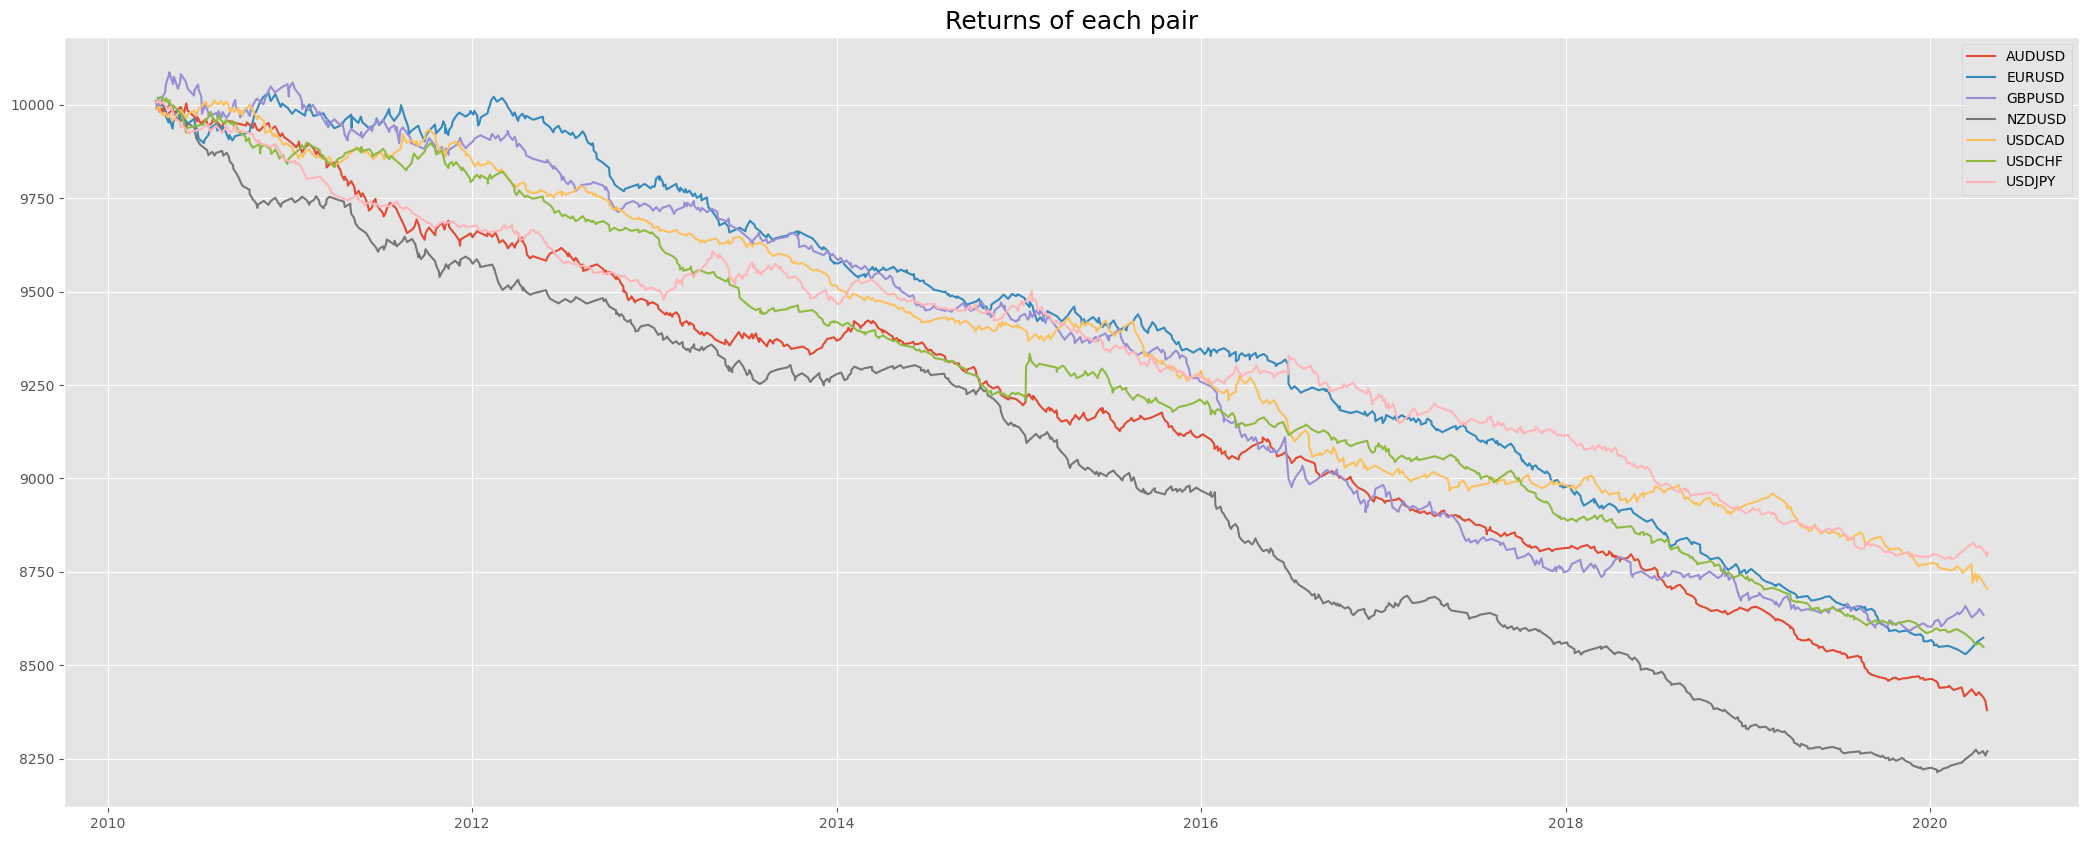

In [10]:

plt.figure(figsize = (26, 10))
for pair in range(len(pairs_list)):
    plt.plot(pairs_results[pair]['cum_res'], label = pairs_list[pair])
plt.legend()
plt.title('Returns of each pair', fontsize = 18)

print('Strategy returns:', round(strategy_results['cum_res'][-1]) - account_size)
